In [1]:
%cd ../

/workspaces/formula1-season-explorer


/workspaces/formula1-season-explorer/venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import os

import numpy as np

from modules.preprocess import make_datamart, add_features, ModelInputData
from modules.utils import load_config
from modules.model import Classifier, Ranker
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

BUCKET_NAME = os.environ.get('BUCKET_NAME')
AWS_ACCESS_KEY_ID = os.environ.get('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = os.environ.get('AWS_SECRET_ACCESS_KEY')
DICT_CONFIG = load_config("./config/config.yml")

# Preprocess

In [5]:
df = make_datamart(bucket_name=BUCKET_NAME)
# Drop null record for training
df = df[~df["position"].isna()]
df = add_features(df)
model_input_data = ModelInputData(df=df)

# Classifier

## Train model

In [49]:
data_train = model_input_data.df.loc[model_input_data.df["season"] < 2023]
data_test = model_input_data.df.loc[model_input_data.df["season"] >= 2023]

X_train = data_train.loc[:, model_input_data.list_col_X]
X_test = data_test.loc[:, model_input_data.list_col_X]
y_train = data_train[model_input_data.col_y] == 1
y_test = data_test[model_input_data.col_y] == 1

In [50]:
classifier = Classifier(
    bucket_name=BUCKET_NAME, 
    aws_access_key_id=AWS_ACCESS_KEY_ID, 
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY, 
    s3_model_key=DICT_CONFIG["s3_model_key"]
)
classifier.train(X_train, X_test, y_train, y_test)

[LightGBM] [Info] Number of positive: 329, number of negative: 5378
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 618
[LightGBM] [Info] Number of data points in the train set: 5707, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[6]	valid_0's auc: 0.921465


In [51]:
y_pred = classifier.predict(X_test)

## Evaluate
- Adhoc check of trained models
- This is only in notebook

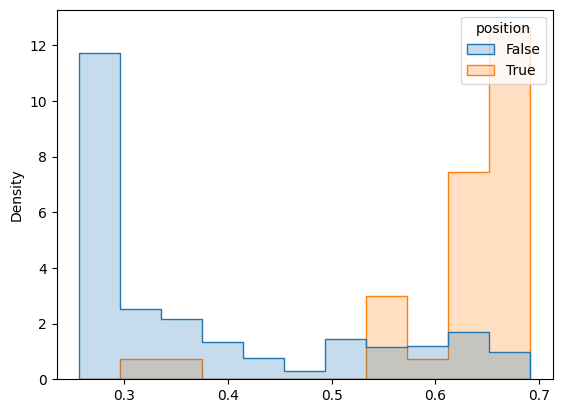

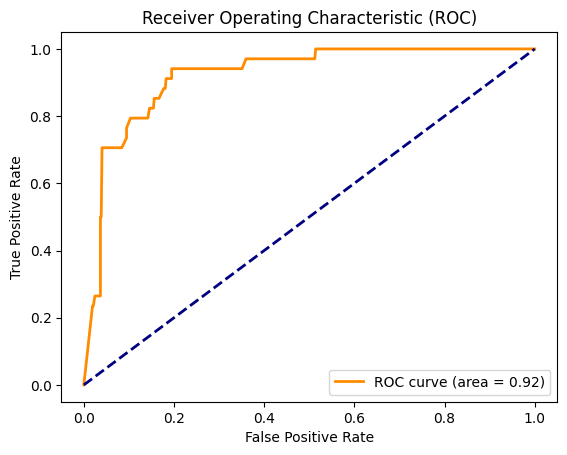

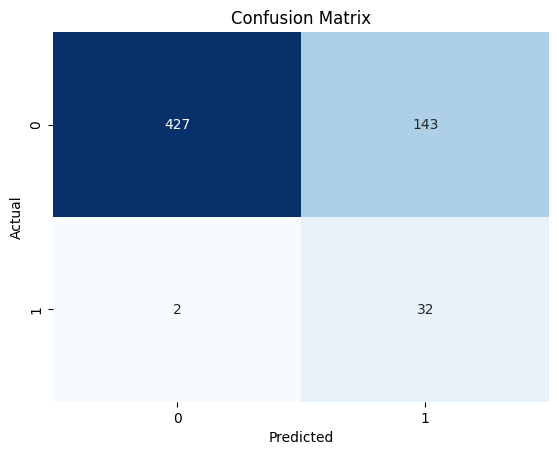

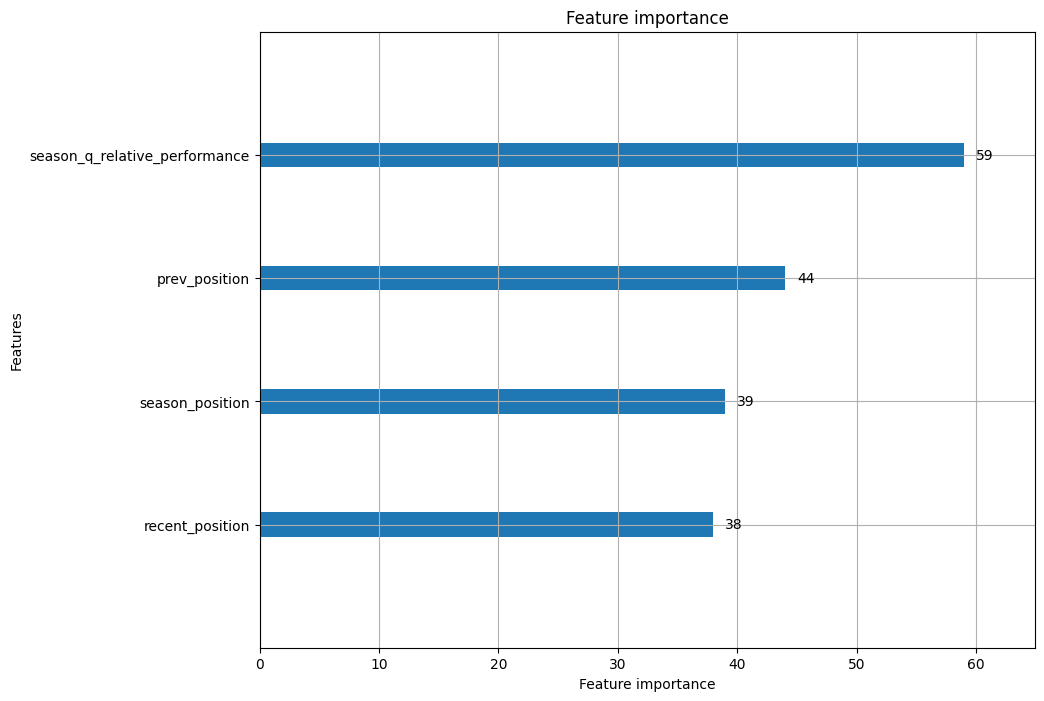

In [53]:
# How well the model is predicting
sns.histplot(x=y_pred, hue=y_test, element="step", stat="density", common_norm=False)


# Area Under the Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
matrix = confusion_matrix(y_test, np.round(y_pred))

plt.figure()
sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Feature importance
lgb.plot_importance(classifier.model, figsize=(10, 8))
plt.show()

## Save model to S3

In [54]:
classifier.save_model()

## Load model from S3 and Predict

In [55]:
classifier_2 = Classifier(
    bucket_name=BUCKET_NAME, 
    aws_access_key_id=AWS_ACCESS_KEY_ID, 
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY, 
    s3_model_key=DICT_CONFIG["s3_model_key"]
)

classifier_2.load_model()

y_pred_2 = classifier_2.predict(X_test)

# Ranker

## Train

In [6]:
model_input_data.df.sort_values(by=["season", "round"], inplace=True)

data_train = model_input_data.df.loc[model_input_data.df["season"] < 2023]
data_test = model_input_data.df.loc[model_input_data.df["season"] >= 2023]
data_train.reset_index(drop=True, inplace=True)
data_test.reset_index(drop=True, inplace=True)


In [7]:
X_train = data_train[model_input_data.list_col_X]
X_test = data_test[model_input_data.list_col_X]
y_train= data_train[model_input_data.col_y]-1
y_test = data_test[model_input_data.col_y]-1

In [8]:
# Make query
query_train = data_train.groupby(["season", "round"]).size().to_numpy()
query_test = data_test.groupby(["season", "round"]).size().to_numpy()

In [9]:
ranker = Ranker(
    bucket_name=BUCKET_NAME, 
    aws_access_key_id=AWS_ACCESS_KEY_ID, 
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY, 
    s3_model_key=DICT_CONFIG["s3_model_key"]
)

ranker.train(X_train, X_test, y_train, y_test, query_train, query_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 618
[LightGBM] [Info] Number of data points in the train set: 5707, number of used features: 4
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	valid_0's ndcg@1: 0.396374	valid_0's ndcg@3: 0.413434	valid_0's ndcg@10: 0.595301


In [10]:
y_pred = ranker.predict(X_test, query_test)

## Evaluate

In [32]:
import seaborn as sns
from sklearn.metrics import ndcg_score

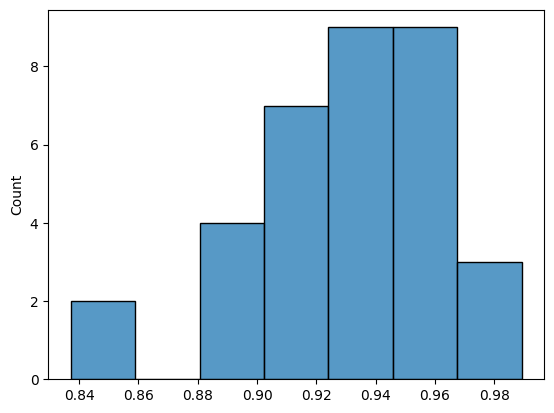

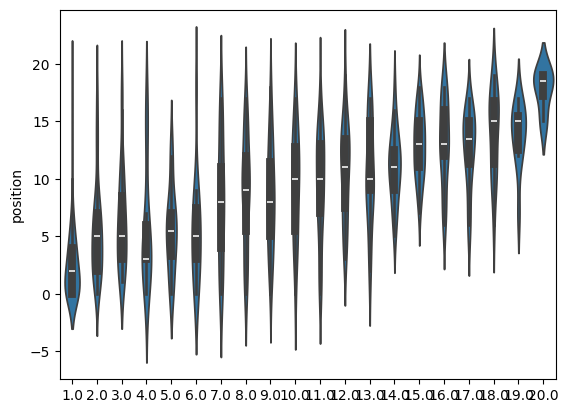

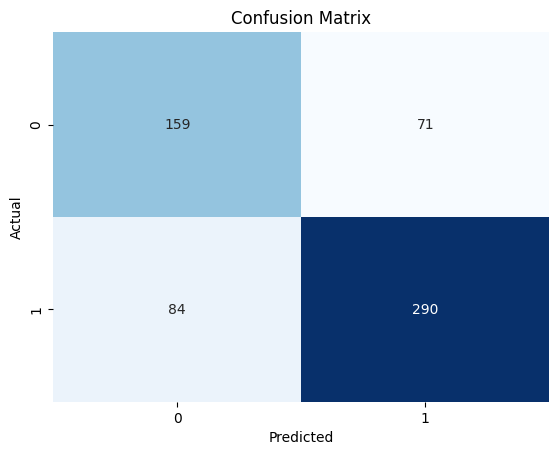

In [33]:
# NDCG distribution for each query
ndcg = []
current_idx = 0
for idx, query in enumerate(query_test):
    ndcg.append(
        ndcg_score(
            y_test.iloc[current_idx: current_idx + query].values.reshape(1, -1), 
            y_pred[current_idx: current_idx + query].reshape(1, -1)
        )
    )
    current_idx += query

sns.histplot(ndcg)
plt.show()

# Relation between prediction and position
sns.violinplot(x=y_pred, y=y_test)
plt.show()


# Confusion Matrix for top 10
matrix = confusion_matrix(y_test<=10, y_pred<=10)
plt.figure()
sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Save model to S3

In [34]:
ranker.save_model()

## Load model and predict

In [35]:
ranker_2 = Ranker(
    bucket_name=BUCKET_NAME, 
    aws_access_key_id=AWS_ACCESS_KEY_ID, 
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY, 
    s3_model_key=DICT_CONFIG["s3_model_key"]
)

ranker_2.load_model()

In [36]:
# If you predict only a round, query is not needed for predict
y_pred_2 = ranker_2.predict(X_test.iloc[-20:])

In [37]:
y_pred_2

array([17, 15, 14,  1,  4,  8,  8, 11, 17,  3,  8, 11,  4, 20,  1, 13,  4,
        4, 17, 15])